In [1]:
# Description: Plot Figure 8 (maps of time-averaged Topographic Sverdrup Balance residual)
#
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        April/2020

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from netCDF4 import Dataset
from xarray import open_dataset
import cartopy as ctpy
import cartopy.crs as crs
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from os.path import isfile
from matplotlib.ticker import FuncFormatter
from scipy.ndimage.filters import gaussian_filter

In [3]:
def cbfmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    if b==0:
        return r'$0$'
    else:
        return r'${}\times10^{{{}}}$'.format(a, b)


def near2(x, y, x0, y0, npts=1, return_index=False):
    """
    USAGE
    -----
    xnear, ynear = near2(x, y, x0, y0, npts=1, return_index=False)

    Finds 'npts' points (defaults to 1) in arrays 'x' and 'y'
    that are closest to a specified '(x0, y0)' point. If
    'return_index' is True (defauts to False), then the
    indices of the closest point(s) are returned.

    Example
    -------
    >>> x = np.arange(0., 100., 0.25)
    >>> y = np.arange(0., 100., 0.25)
    >>> x, y = np.meshgrid(x, y)
    >>> x0, y0 = 44.1, 30.9
    >>> xn, yn = near2(x, y, x0, y0, npts=1)
    >>> print("(x0, y0) = (%f, %f)"%(x0, y0))
    >>> print("(xn, yn) = (%f, %f)"%(xn, yn))
    """
    x, y = map(np.array, (x, y))
    shp = x.shape

    xynear = []
    xyidxs = []
    dx = x - x0
    dy = y - y0
    dr = dx**2 + dy**2
    for n in range(npts):
        xyidx = np.unravel_index(np.nanargmin(dr), dims=shp)
        if return_index:
            xyidxs.append(xyidx)
        xyn = (x[xyidx], y[xyidx])
        xynear.append(xyn)
        dr[xyidx] = np.nan

    if npts==1:
        xynear = xynear[0]
        if return_index:
            xyidxs = xyidxs[0]

    if return_index:
        return xyidxs
    else:
        return xynear


def bmap(ax, proj, bbox, draw_labels=True, land=None, segment='Ross'):
    ax.coastlines('10m', zorder=9999)
    if land is not None:
        ax.add_feature(land, zorder=999)
    if segment=='Ross':
        gl = ax.gridlines(xlocs=[-170, -150, -130, 170], ylocs=[-78, -75, -72, -69], draw_labels=draw_labels, linewidth=0, crs=ccrs.PlateCarree())
    elif segment=='WAP':
        gl = ax.gridlines(xlocs=[-73, -69, -63, -57], ylocs=[-73, -70, -67, -64, -61], draw_labels=draw_labels, linewidth=0, crs=ccrs.PlateCarree())
    elif segment=='Weddell':
        gl = ax.gridlines(xlocs=[-60, -40, -20], ylocs=[-78, -72, -66, -60], draw_labels=draw_labels, linewidth=0, crs=ccrs.PlateCarree())
    elif segment=='W-EA':
        gl = ax.gridlines(xlocs=[-10, 10, 40, 60], ylocs=[-70, -66, -62], draw_labels=draw_labels, linewidth=0, crs=ccrs.PlateCarree())
    elif segment=='E-EA':
        gl = ax.gridlines(xlocs=[80, 100, 120, 140, 160], ylocs=[-70, -66, -62], draw_labels=draw_labels, linewidth=0, crs=ccrs.PlateCarree())
    elif segment=='Amundsen-Bellingshausen':
        gl = ax.gridlines(draw_labels=draw_labels, xlocs=[-125, -105, -85], ylocs=[-74, -72, -70, -69], linewidth=0, crs=ccrs.PlateCarree())

    if draw_labels:
        if segment in ['Amundsen-Bellingshausen', 'Weddell', 'W-EA']:
            gl.xlabels_top = gl.ylabels_left = True
            gl.xlabels_bottom = gl.ylabels_right = False
        else:
            gl.xlabels_top = gl.ylabels_right = True
            gl.xlabels_bottom = gl.ylabels_left = False

        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

    return ax

/home/andre/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: Mean of empty slice


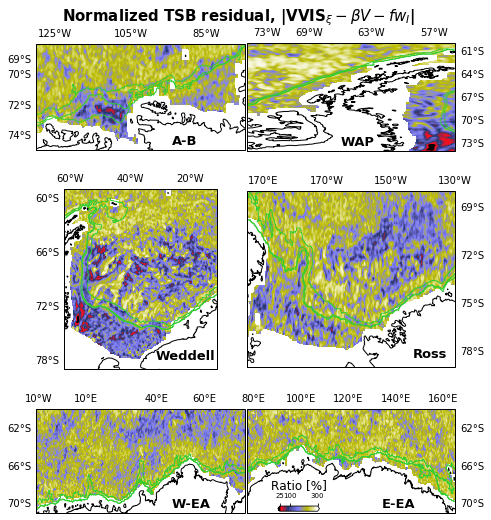

In [4]:
plt.close('all')
head_data = '../../data_reproduce_figs/'
head = head_data

terms = ['curlvdiff', 'curlnonl', 'betav', 'stretchp', 'errcor', 'curlpgrad', 'curlhdiff', 'res']
terms_titles = dict(Icurlnonl=r"-NONL$_\xi$", Ibetav=r"$-\beta V$", Istretchp="$-fw_I$", Ierrcor=r"ERRCOR", Icurlpgrad=r"PGRD$_\xi$", Icurlhdiff=r"HVIS$_\xi$", Icurlvdiff=r"VVIS$_\xi$", Ires=r"RES$_\xi$")
termsi = np.array(['I'+term for term in terms])
terms = termsi

fname = 'vortbdgt_2005-2009avgzint.nc'

# Get segment lat/lon limits.
segs_lims = {
'Amundsen-Bellingshausen':[-130., -75., -75., -68.],
'WAP':[-75., -55., -74., -60.],
'Weddell':[-62., -11., -79., -59.],
'Ross':[345., 410., -79., -68.],
'W-EA':[-11., 77., -71., -60.],
'E-EA':[77., 165., -71., -60.],
}
segments = segs_lims.keys()
fileij = head_data + 'ijisobaths.npz'
#=======================================

nc = Dataset(head_data + 'POP-dzu_dzt_kzit_subsetSO.nc')
lont, latt = nc['TLONG'][:], nc['TLAT'][:]

# Get isobath indices.
fisobs = head_data + 'isobaths.nc'
ncx = Dataset(fisobs)
iisob, misob, oisob = 800, 1000, 2500
xi = ncx["%d m isobath (T-points)"%iisob]['xiso'][:]
yi = ncx["%d m isobath (T-points)"%iisob]['yiso'][:]
di = ncx["%d m isobath (T-points)"%iisob]['diso'][:]
xm = ncx["%d m isobath (T-points)"%misob]['xiso'][:]
ym = ncx["%d m isobath (T-points)"%misob]['yiso'][:]
dm = ncx["%d m isobath (T-points)"%misob]['diso'][:]
xo = ncx["%d m isobath (T-points)"%oisob]['xiso'][:]
yo = ncx["%d m isobath (T-points)"%oisob]['yiso'][:]
do = ncx["%d m isobath (T-points)"%oisob]['diso'][:]

fmt = 'png'
kwsavefig = dict(fmt=fmt, bbox_inches='tight', pad_inches=0.1)
lightgray = [.85]*3
darkgray = [.35]*3

if isfile(fileij):
    d = np.load(fileij)
    dijs = ['ii', 'ji', 'im', 'jm', 'io', 'jo']
    for dij in dijs:
        vars().update({dij:d[dij]})
else:
    Ii, Ji, Im, Jm, Io, Jo = [], [], [], [], [], []
    for xx, yy in zip(xi, yi):
        xa, ya = near2(lont, latt, xx, yy, return_index=True)
        Ii.append(xa); Ji.append(ya)
    for xx, yy in zip(xm, ym):
        xa, ya = near2(lont, latt, xx, yy, return_index=True)
        Im.append(xa); Jm.append(ya)
    for xx, yy in zip(xo, yo):
        xa, ya = near2(lont, latt, xx, yy, return_index=True)
        Io.append(xa); Jo.append(ya)
    d = dict(ii=Ii, ji=Ji, im=Im, jm=Jm, io=Io, jo=Jo)
    np.savez(fileij, **d)

ds = open_dataset(head+fname)

Ires = np.ma.masked_invalid(ds['Ires'])
Icurlnonl = np.ma.masked_invalid(ds['Icurlnonl'])
Icurlhdiff = np.ma.masked_invalid(ds['Icurlhdiff'])
Istretchp = np.ma.masked_invalid(ds['Istretchp'].values)
Icurlvdiff = np.ma.masked_invalid(ds['Icurlvdiff'].values)
Ibetav = np.ma.masked_invalid(ds['Ibetav'].values)
norm_term = np.nanmean(np.dstack((np.abs(Istretchp), np.abs(Ibetav), np.abs(Icurlvdiff), np.abs(Icurlhdiff), np.abs(Icurlnonl), np.abs(Ires))), axis=2)

Res_Sv_lin = np.abs(Ibetav + Istretchp + Icurlvdiff)

# Smooth and normalize TSB residual.
lont_AB = lont.copy()
latt_AB = latt.copy()
Res_Sv_lin_AB = Res_Sv_lin.copy()
norm_term_AB = norm_term.copy()


def hglue(arr, ncut=1800):
    return np.hstack((arr[:,:ncut], arr[:,-ncut:-1]))

lont_AB, latt_AB, Res_Sv_lin_AB, norm_term_AB = map(hglue, (lont_AB, latt_AB, Res_Sv_lin_AB, norm_term_AB))

sig = 2
mode = 'wrap'
Res_Sv_lin = gaussian_filter(Res_Sv_lin, sig, mode=mode)
norm_term = gaussian_filter(norm_term, sig, mode=mode)
Res_Sv_lin_AB = gaussian_filter(Res_Sv_lin_AB, sig, mode=mode)
norm_term_AB = gaussian_filter(norm_term_AB, sig, mode=mode)
Res_Sv = 100*Res_Sv_lin/norm_term
Res_Sv_AB = 100*Res_Sv_lin_AB/norm_term_AB



vvmi, vvma = 25, 300

# Plot.
proj1 = ccrs.PlateCarree(central_longitude=0)
proj2 = ccrs.PlateCarree(central_longitude=180)

fig = plt.figure(figsize=(7.5, 10))

axs = []
axs.append(fig.add_subplot(321, projection=proj1))
axs.append(fig.add_subplot(322, projection=proj1))
axs.append(fig.add_subplot(323, projection=proj1))
axs.append(fig.add_subplot(324, projection=proj2)) # Ross Sea, central_longitude=180.
axs.append(fig.add_subplot(325, projection=proj1))
axs.append(fig.add_subplot(326, projection=proj1))

for n, segment in enumerate(segments):
    ax = axs[n]
    bbox = segs_lims[segment]

    if segment=='Ross':
        central_longitude = 180
    else:
        central_longitude = 0
    proj = ccrs.PlateCarree(central_longitude=central_longitude)

    ax = bmap(ax, proj, bbox, segment=segment, draw_labels=True, land=None)
    ax.set_extent(bbox, crs=proj)
    ax.set_aspect(4)

    if segment=='Amundsen-Bellingshausen':
        cs = ax.pcolormesh(lont_AB, latt_AB, Res_Sv_AB, vmin=vvmi, vmax=vvma, cmap=plt.cm.gist_stern, zorder=2, transform=ccrs.PlateCarree())
    else:
        cs = ax.pcolormesh(lont, latt, Res_Sv, vmin=vvmi, vmax=vvma, cmap=plt.cm.gist_stern, zorder=2, transform=ccrs.PlateCarree())

    fi = ~np.logical_or(xi<=-179.9, xi>179.9)
    fm = ~np.logical_or(xm<=-179.9, xm>179.9)
    fo = ~np.logical_or(xo<=-179.9, xo>179.9)
    ax.plot(xi[fi], yi[fi], 'limegreen', linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot(xm[fm], ym[fm], 'limegreen', linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot(xo[fo], yo[fo], 'limegreen', linewidth=0.8, transform=ccrs.PlateCarree())


    if segment=='Amundsen-Bellingshausen':
        xt, yt, fontsize = 0.65, 0.05, 13
    elif segment=='WAP':
        xt, yt, fontsize = 0.45, 0.05, 13
    elif segment=='Weddell':
        xt, yt, fontsize = 0.6, 0.05, 13
    elif segment=='Ross':
        xt, yt, fontsize = 0.8, 0.05, 13
    elif segment=='W-EA':
        xt, yt, fontsize = 0.65, 0.05, 13
    elif segment=='E-EA':
        xt, yt, fontsize = 0.65, 0.05, 13

    if segment=='Amundsen-Bellingshausen':
        ax.text(xt, yt, "A-B", fontsize=fontsize, fontweight='black', transform=ax.transAxes)
    else:
        ax.text(xt, yt, segment, fontsize=fontsize, fontweight='black', transform=ax.transAxes)

    if segment=='E-EA':
        caxx, caxy = 0.15, 0.015
        cbaxes = ax.inset_axes([caxx, caxy, 0.20, 0.05])

        cb = fig.colorbar(mappable=cs, cax=cbaxes, orientation='horizontal', extend='both')
        cb.set_ticks([vvmi, 100, vvma])
        cb.ax.xaxis.set_tick_params(labelsize=7)
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.xaxis.set_label_position('top')
        cb.set_label(r"Ratio [%]", fontsize=12)


    if segment=='Ross':
        ax.set_aspect(5)
    elif segment=='WAP':
        ax.set_aspect(0.74)
    elif segment=='Weddell':
        ax.set_aspect(3)
    elif segment in ['W-EA', 'E-EA']:
        ax.set_aspect(4)
    else:
        ax.set_aspect(4)

fig.suptitle(r"Normalized TSB residual, |VVIS$_\xi - \beta V - fw_I$|", fontsize=15, fontweight='black', y=0.88)

fig.subplots_adjust(hspace=0.01, wspace=0.01)
plt.show()

fig.savefig("fig08.png", dpi=300, bbox_inches="tight")